### Run LLaVa-v1.6 on Sagemaker inference endpoint - None_Streaming

* Use a Sagemaker notebook instance to run below codes(e.g. ml.t3.medium instance)
* Sagemaker inference endpoint use ml.g5.2xlarge
* Codes referred to [LLaVA official repo](https://github.com/haotian-liu/LLaVA)

In [1]:
!pip install boto3 sagemaker awscli -Uq

In [ ]:
import sagemaker
import boto3
import os

role = sagemaker.get_execution_role() 
sess = sagemaker.session.Session() 
bucket = sess.default_bucket()
region = sess._region_name
account_id = sess.account_id()
smr_client = boto3.client('sagemaker-runtime')

In [ ]:
from sagemaker import image_uris

inference_image_uri = image_uris.retrieve(
    framework="djl-deepspeed",
    region=region,
    version="0.26.0",
)
print(f"Container image is going to be used ---- > {inference_image_uri}")

In [4]:
from pathlib import Path

deploy_code_path = Path("./llava_deploy_codes")
deploy_code_path.mkdir(exist_ok=True)

In [ ]:
%%writefile ./llava_deploy_codes/model.py
import torch
import os
import boto3
import requests
import logging

from PIL import Image
from io import BytesIO
from transformers import TextStreamer
from djl_python import Input, Output
from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.conversation import conv_templates, SeparatorStyle
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from llava.mm_utils import process_images, tokenizer_image_token, get_model_name_from_path

model = None
tokenizer = None
image_processor = None
context_len = None
model_name = None
conv = None
image = None
image_tensor = None
image_size = None

s3 = boto3.client('s3')

def check_file_existence(s3_path):
    bucket_name = s3_path.split("//")[1].split("/")[0]
    object_key = "/".join(s3_path.split("//")[1].split("/")[1:])
    try:
        s3.head_object(Bucket=bucket_name, Key=object_key)
        return True
    except ClientError as e:
        if e.response['Error']['Code'] == '404':
            return False
        else:
            raise

def load_image(image_file):
    if image_file.startswith('http://') or image_file.startswith('https://'):
        response = requests.get(image_file)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    elif image_file.startswith('s3://'):
        file_path = os.path.join("/tmp/", os.path.basename(image_file))
        if check_file_existence(image_file):
            bucket_name = image_file.split("//")[1].split("/")[0]
            object_key = "/".join(image_file.split("//")[1].split("/")[1:])
            s3.download_file(bucket_name, object_key, file_path)
            image = Image.open(file_path).convert('RGB')
        else:
            raise ValueError('Image file does not exist. Upload files to S3 first!')
    else:
        image = Image.open(image_file).convert('RGB')
    return image

def get_image_tensor(image_url):
    image = load_image(image_url)
    image_size = image.size
    image_tensor = process_images([image], image_processor, model.config)
    if type(image_tensor) is list:
        image_tensor = [image.to(model.device, dtype=torch.float16) for image in image_tensor]
    else:
        image_tensor = image_tensor.to(model.device, dtype=torch.float16)
    return image, image_tensor, image_size

def load_model(properties):
    disable_torch_init()
    
    model_location = properties['model_dir']
    if "model_id" in properties:
        model_location = properties['model_id']
    logging.info(f"Loading model in {model_location}")
    model_name = get_model_name_from_path(model_location)
    tokenizer, model, image_processor, context_len = load_pretrained_model(
        model_path=model_location,
        model_base=None,
        model_name=model_name
    )
    
    return tokenizer, model, image_processor, context_len, model_name

def handle(inputs: Input):
    global model, tokenizer, image_processor, context_len, model_name, conv, image, image_tensor, image_size
    
    if not model:
        tokenizer, model, image_processor, context_len, model_name = load_model(inputs.get_properties())
    if inputs.is_empty():
        return None
    
    data = inputs.get_as_json()
    temperature = data["params"].pop("temperature", 0.2)
    max_new_tokens = data["params"].pop("max_new_tokens", 512)
    reset_cov = data["params"].pop("reset", "")
    
    if reset_cov == "enable":
        conv = None
    
    if not conv:
        if "mistral" in model_name.lower():
            conv_mode = "mistral_instruct"
        else:
            conv_mode = "llava_v1"
        conv = conv_templates[conv_mode].copy()
    roles = conv.roles
    
    inp = data.pop("input_text", "")
    inp = f"{roles[0]}: {inp}"
    
    image_url = data.pop("input_image", "")
    if image_url:
        image, image_tensor, image_size = get_image_tensor(image_url)
    else:
        image = None
    
    if image is not None:
        # first message
        if model.config.mm_use_im_start_end:
            inp = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + inp
        else:
            inp = DEFAULT_IMAGE_TOKEN + '\n' + inp
        conv.append_message(conv.roles[0], inp)
        image = None
    else:
        # later messages
        conv.append_message(conv.roles[0], inp)
    
    conv.append_message(conv.roles[1], None)
    prompt = conv.get_prompt()
    print(prompt)
    
    input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).to(model.device)
    stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
    keywords = [stop_str]
    # streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)
    
    with torch.inference_mode():
        output_ids = model.generate(
            input_ids,
            images=image_tensor,
            image_sizes=[image_size],
            do_sample=True if temperature > 0 else False,
            temperature=temperature,
            max_new_tokens=max_new_tokens,
            streamer=None,
            use_cache=True)
    outputs = tokenizer.decode(output_ids[0]).strip()
    conv.messages[-1][-1] = outputs
    
    result = {"message": outputs, "conv_history": conv.messages}
    
    return Output().add(result)

> You can choose vicuna or mistral by modifying "model_id" as below

In [ ]:
%%writefile ./llava_deploy_codes/serving.properties
engine=Python
# option.model_id=liuhaotian/llava-v1.6-vicuna-7b
option.model_id=liuhaotian/llava-v1.6-mistral-7b

In [ ]:
%%writefile ./llava_deploy_codes/requirements.txt
boto3
git+https://github.com/haotian-liu/LLaVA

In [8]:
import tarfile

folder_path = 'llava_deploy_codes'
output_filename = 'model.tar.gz'

with tarfile.open(output_filename, "w:gz") as tar:
    tar.add(folder_path, arcname=os.path.basename(folder_path))

In [ ]:
s3_code_prefix = "llava_deploy_codes"

s3_code_artifact = sess.upload_data("model.tar.gz", bucket, s3_code_prefix)
print(f"S3 Code or Model tar ball uploaded to --- > {s3_code_artifact}")

In [ ]:
from sagemaker.model import Model

instance_type = "ml.g5.2xlarge"
model_name = sagemaker.utils.name_from_base("llava-v16-7b")

model = Model(
    sagemaker_session=sess, 
    image_uri=inference_image_uri, 
    model_data=s3_code_artifact,
    name=model_name,
    role=role)

model.deploy(
    initial_instance_count=1,
    instance_type=instance_type,
    endpoint_name=model_name,
    container_startup_health_check_timeout=900
)

#### Test image from public address

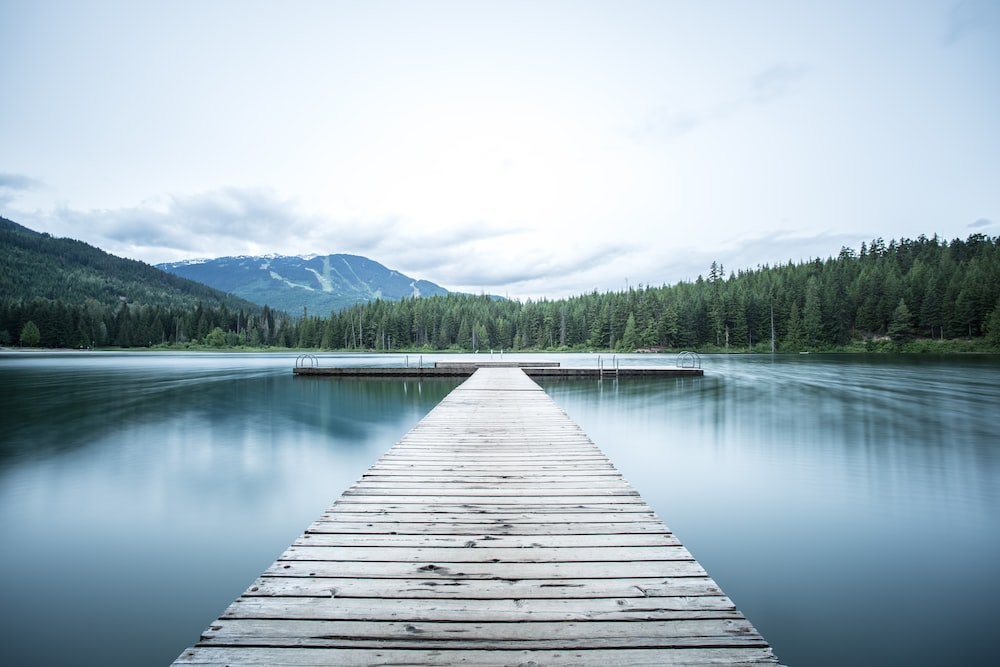

In [11]:
import requests
from PIL import Image

image_url = "https://llava-vl.github.io/static/images/view.jpg"
Image.open(requests.get(image_url, stream=True).raw)

In [12]:
import json

text = "Describe the image?"
params = {
    "temperature": 0.2,
    "max_new_tokens": 512,
    "reset": "enable" # Use this parameter to start a new conversation
}

body = {"input_text": text, "input_image": image_url, "params": params}

response = smr_client.invoke_endpoint(
    EndpointName=model_name, 
    Body=json.dumps(body),
    ContentType="application/json"
    )

# Decodes and prints the response body:
result = json.loads(response['Body'].read().decode('utf-8'))
print("Response is:\n", result['message'], '\n')
print("Conversation is:\n", result['conv_history'])

Response is:
 <s> The image shows a serene natural setting with a wooden dock extending into a calm body of water. The dock appears to be made of weathered planks and is surrounded by a tranquil forest with coniferous trees. In the background, there is a clear view of a mountain range with snow-capped peaks, suggesting that the location might be at a high altitude or in a cold climate. The sky is overcast with soft, diffused light, which gives the scene a peaceful and somewhat ethereal quality. The water reflects the surrounding landscape, adding to the sense of tranquility and isolation. </s> 

Conversation is:
 [['USER', '<image>\nUSER: Describe the image?'], ['ASSISTANT', '<s> The image shows a serene natural setting with a wooden dock extending into a calm body of water. The dock appears to be made of weathered planks and is surrounded by a tranquil forest with coniferous trees. In the background, there is a clear view of a mountain range with snow-capped peaks, suggesting that the

In [13]:
import json

text = "How about weather looks like?"
params = {
    "temperature": 0.2,
    "max_new_tokens": 512,
    # "reset": "enable" # Use this parameter to start a new conversation
}

body = {"input_text": text, "params": params}

response = smr_client.invoke_endpoint(
    EndpointName=model_name, 
    Body=json.dumps(body),
    ContentType="application/json"
    )

# Decodes and prints the response body:
result = json.loads(response['Body'].read().decode('utf-8'))
print("Response is:\n", result['message'], '\n')
print("Conversation is:\n", result['conv_history'])

Response is:
 <s> The weather in the image appears to be overcast, with a cloudy sky that diffuses the light evenly across the scene. There are no visible signs of rain or snow, and the overall atmosphere seems calm and serene. The absence of harsh sunlight or strong winds suggests a relatively calm and stable weather condition. </s> 

Conversation is:
 [['USER', '<image>\nUSER: Describe the image?'], ['ASSISTANT', '<s> The image shows a serene natural setting with a wooden dock extending into a calm body of water. The dock appears to be made of weathered planks and is surrounded by a tranquil forest with coniferous trees. In the background, there is a clear view of a mountain range with snow-capped peaks, suggesting that the location might be at a high altitude or in a cold climate. The sky is overcast with soft, diffused light, which gives the scene a peaceful and somewhat ethereal quality. The water reflects the surrounding landscape, adding to the sense of tranquility and isolation

#### Test image from S3 Bucket

> Scenario: Use LLaVa to caption images for Stable Diffusion training or inference

In [14]:
# Download image to local
image_url = 'https://raw.githubusercontent.com/terrificdm/multimodal-sagemaker/main/image/demo.jpg'
response = requests.get(image_url)
if response.status_code == 200:
    image_data = response.content
    file_name = 'demo.jpg'
    with open(file_name, 'wb') as file:
        file.write(image_data)
else:
    print('Failed:', response.status_code)

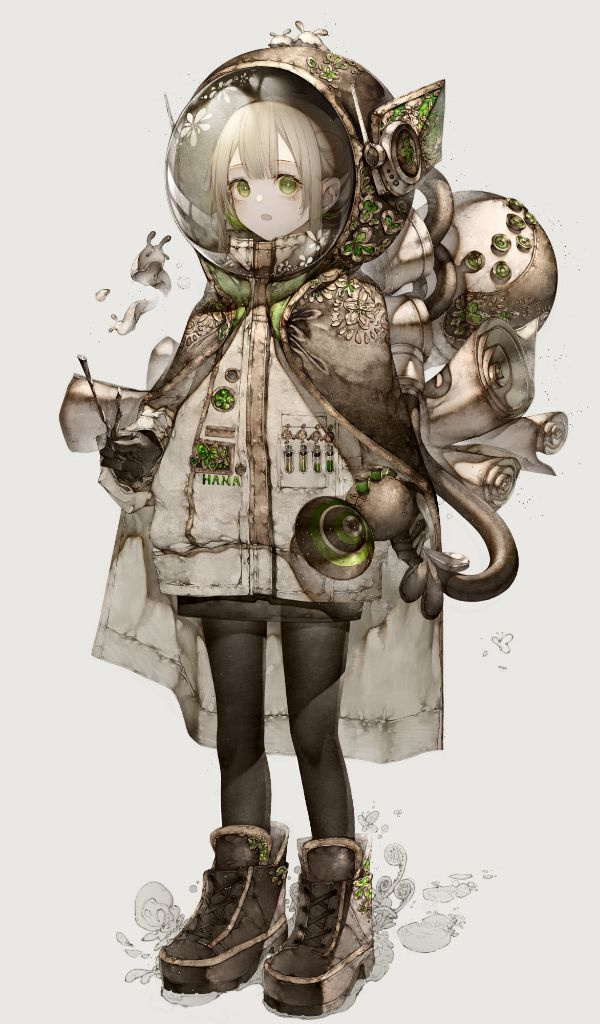

In [15]:
Image.open(requests.get(image_url, stream=True).raw)

In [16]:
# Upload image from local to S3 bucket

from sagemaker.s3 import S3Uploader

s3_image_uri=S3Uploader.upload(local_path=f"./{file_name}", desired_s3_uri=f"s3://{bucket}/iamge")
print("Image has been uploaded to:", s3_image_uri)

Image has been uploaded to: s3://sagemaker-us-east-1-091166060467/iamge/demo.jpg


In [17]:
text = """You are prompt engineer for Stable Diffusion. Your job is to extract description from the image then rewrite description into a prompt as much detail as possible to let Stable Diffusion understand.

Here is an example of the format for the prompt:
Snow Princess, smooth soft skin, symmetrical, soft lighting, detailed face, looking into camera.

Here are some important rules you need to obey all the time:
- The prompt should capture key elements such as the main subject, setting, artistic style, composition, image quality, color tone, filter, and camera specifications, and any other elements crucial for the image.
- For images of people, include specific details like gender, nationality, attire, actions, pose, expressions, accessories, makeup, composition type, age, etc. 
- For other image categories, apply appropriate and common descriptive as well. Recognize and tag any celebrities, well-known landmark or IPs if clearly featured in the image.
- The prompt should be accurate and non-duplicative. It will be used for image re-creation, so the closer the resemblance to the original image, the better the tag quality.
- The format of final prompt must be similar to the example above which is comprised of keywords separated by comas."""

params = {
    "temperature": 0.2,
    "max_new_tokens": 512,
    "reset": "enable" # Use this parameter to start a new conversation
}

body = {"input_text": text, "input_image": s3_image_uri, "params": params}

response = smr_client.invoke_endpoint(
    EndpointName=model_name, 
    Body=json.dumps(body),
    ContentType="application/json"
    )

# Decodes and prints the response body:
result = json.loads(response['Body'].read().decode('utf-8'))
print("Response is:\n", result['message'], '\n')
print("Conversation is:\n", result['conv_history'])

Response is:
 <s> Stylish Anime Girl, futuristic space suit, detailed face, green eyes, blonde hair, holding a small green plant, wearing a white jacket with a green collar, black pants, brown boots, carrying a large green and white backpack, surrounded by various space debris and floating in space, looking into the camera. </s> 

Conversation is:
 [['USER', '<image>\nUSER: You are prompt engineer for Stable Diffusion. Your job is to extract description from the image then rewrite description into a prompt as much detail as possible to let Stable Diffusion understand.\n\nHere is an example of the format for the prompt:\nSnow Princess, smooth soft skin, symmetrical, soft lighting, detailed face, looking into camera.\n\nHere are some important rules you need to obey all the time:\n- The prompt should capture key elements such as the main subject, setting, artistic style, composition, image quality, color tone, filter, and camera specifications, and any other elements crucial for the imag